In [ ]:
python -m spacy download en_core_web_sm

In [1]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import pandas as pd
import numpy as np
from scipy.stats import randint
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()


df = pd.read_csv('stock_data.csv')
df['Text'] = df['Text'].astype(str)
df['Date'] = pd.to_datetime(df['Date']).dt.date
df['Sentiment'] = df['Sentiment'].astype(np.int64)
print(df.info())

# test_data = pd.read_csv('./raw_news/NewsData-2023-05-05.csv')
# test_data['Date'] = pd.to_datetime(test_data['Date'])
# # test_data= test_data.iloc[:,:-1]
# test_data.rename(columns = {'Headline':'Text'}, inplace = True)
# test_data['Text'] = test_data['Text'].astype(str)
# # test_data =test_data.replace(r'^\s*$', np.nan, regex=True)
# # test_data = test_data[['Text','Date']].merge(df, on=['Text','Date'], how='left')
# # test_data = test_data[test_data['Text'].str.contains("\?")==False]
# print(test_data.info())
# print(df['Sentiment'].value_counts())

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

to_remove = ['up', 'down','low','high','below','less','fall','Daily Voice']
new_stopwords = set(stopwords.words('english')).difference(to_remove)
stemmer = SnowballStemmer(language='english')
def text_data_cleaning(sentence):
    sent = preprocess_text(sentence)
    doc = nltk.word_tokenize(sent)
    lemma =[lemmatizer.lemmatize(word, pos ="v") for word in doc]
    return append_message(lemma)
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    sentence = sen.lower()
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub('rs|cr|crore|point|points|pt|stock', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) 
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  
    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(new_stopwords) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

def append_message(text):
  str = " "
  return (str.join(text))

df['Tok_text'] = df['Text'].apply(text_data_cleaning)
df['Tok_text'] = df['Tok_text'].astype(str)
tf_idf_vect = TfidfVectorizer()

df2 = df.iloc[:,2:]

df_train, df_test = train_test_split(df2, test_size=0.3, random_state=42,
                                     stratify=df2['Sentiment'])
print(df2.info())
X_train = tf_idf_vect.fit_transform(df_train['Tok_text'])
y_train = df_train['Sentiment']
X_test = tf_idf_vect.transform(df_test['Tok_text'])
y_test = df_test['Sentiment']

# test_data['Tok_text'] = test_data['Text'].apply(text_data_cleaning)
# x_test = tf_idf_vect.transform(test_data['Tok_text'])
# print(x_test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52804 entries, 0 to 52803
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       52804 non-null  object
 1   Date       52804 non-null  object
 2   Sentiment  52804 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52804 entries, 0 to 52803
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  52804 non-null  int64 
 1   Tok_text   52804 non-null  object
dtypes: int64(1), object(1)
memory usage: 825.2+ KB
None


In [8]:
adani = df[df['Text'].str.contains("Adani | adani")]
adani.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1317 entries, 2 to 52744
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       1317 non-null   object
 1   Date       1317 non-null   object
 2   Sentiment  1317 non-null   int64 
 3   Tok_text   1317 non-null   object
dtypes: int64(1), object(3)
memory usage: 51.4+ KB


In [18]:
import datetime
from datetime import datetime
start_date = '2023-02-10'
start_date = datetime.strptime(start_date, "%Y-%m-%d").date()
check  = df[df['Date'] == start_date]

In [40]:
adani['Date'].value_counts()

Date
2023-01-27    39
2023-02-03    37
2023-02-14    33
2023-01-31    31
2023-02-09    31
2023-02-10    29
2023-01-30    29
2023-02-01    29
2023-02-02    29
2023-02-08    29
2023-02-07    27
2023-02-06    23
2023-02-24    22
2023-02-13    21
2023-02-22    19
2023-02-15    18
2023-03-08    15
2023-02-20    15
2023-02-04    13
2023-03-06    13
2023-02-16    13
2023-01-28    12
2023-03-13    11
2021-06-14    11
2023-01-25    11
2023-04-10    11
2021-06-15    10
2023-05-02    10
2022-07-11     9
2023-03-20     9
2023-02-23     9
2023-03-09     9
2023-03-14     9
2023-02-21     8
2023-01-18     8
2023-05-04     7
2023-01-29     7
2023-02-17     7
2023-01-19     7
2022-09-02     7
2022-10-03     6
2023-04-03     6
2021-04-06     6
2023-03-05     5
2023-04-12     5
2023-02-18     5
2023-03-24     5
2021-03-23     5
2022-12-06     5
2023-03-10     5
2023-03-12     4
2022-05-16     4
2022-04-01     4
2022-02-08     4
2021-08-06     4
2023-04-20     4
2023-05-03     4
2020-11-04     4
2021-02-1

In [13]:
icici = df[df['Text'].str.contains("ICICI | ICICI")]
icici.info()

<class 'pandas.core.frame.DataFrame'>
Index: 795 entries, 173 to 52125
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       795 non-null    object
 1   Date       795 non-null    object
 2   Sentiment  795 non-null    int64 
 3   Tok_text   795 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.1+ KB


In [33]:
start_date = datetime.strptime("2023-05-04", "%Y-%m-%d").date()
adani_data = df[(df['Date'] == start_date)]
adani_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 52315 to 52755
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       179 non-null    object
 1   Date       179 non-null    object
 2   Sentiment  179 non-null    int64 
 3   Tok_text   179 non-null    object
dtypes: int64(1), object(3)
memory usage: 7.0+ KB


In [20]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Your code here

def filter_news(news_data, company_filter):
    news_data['Text'] = news_data['Text'].apply(str.lower)
    company_filter['Symbol'] = company_filter['Symbol'].apply(str).apply(str.lower)
    company_filter['Company Name'] = company_filter['Company Name'].apply(str).apply(str.lower)
    final_data = pd.DataFrame()
    news_data['Text'] = news_data['Text'].str.replace('[^\w\s]', ' ')
    news_data['Text'] = " "+news_data['Text']+" "

    # iterate all company names to find out the match
    for i in range(len(company_filter)-1):
        try:
            keyword = " "+company_filter["Symbol"][i]+" "
            CompanyName = " "+company_filter["Company Name"][i]+" "
            l=[" global "," wealth "," take "," focus "," worth "]
            if(keyword == 'ttl'):
                continue
            
            if(keyword in l):
                print(keyword)
                print(news_data['Text'])
                contain_values = news_data[(news_data['Text'].str.contains(keyword))&(news_data['Text'].str.contains(CompanyName))]
                contain_values['Symbol'] = company_filter["Symbol"][i]
                contain_values['Company Name'] = company_filter["Company Name"][i]
                final_data = final_data.append(contain_values, ignore_index=True)

            else:
                contain_values = news_data[(news_data['Text'].str.contains(keyword))|(news_data['Text'].str.contains(CompanyName))]
                contain_values['Symbol'] = company_filter["Symbol"][i]
                contain_values['Company Name'] = company_filter["Company Name"][i]
                final_data = final_data.append(contain_values, ignore_index=True)

        except:
            pass
            # print("Company name is small at index ", l)

    return final_data


comany = pd.read_csv('company.csv')
final = filter_news(check,comany)

 global 
204       sebi issues consultation paper on role, oblig...
205       sebi proposes changes in norms pertaining to ...
206       indore civic body green bond subscribed 5.4 t...
207       sensex snaps 2-day winning run amid weak glob...
208       awaiting sebi response, says nse chief ashish...
                               ...                        
29329                        board declares 300% dividend 
29330                   morgan stanley still ‘overweight’ 
29331                    metal stocks drag, realty shines 
29332       adani group companies to see weight reduction 
29359                                         shares rise 
Name: Text, Length: 150, dtype: object
 wealth 
204       sebi issues consultation paper on role, oblig...
205       sebi proposes changes in norms pertaining to ...
206       indore civic body green bond subscribed 5.4 t...
207       sensex snaps 2-day winning run amid weak glob...
208       awaiting sebi response, says nse chief ashish...

In [21]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame


In [ ]:
Date
2023-05-04    179

In [31]:
adani_data['Date'].value_counts()

Date
2023-05-04    179
2023-02-13    165
2023-05-02    161
2023-02-08    160
2023-02-09    159
2023-05-03    155
2023-02-14    155
2023-02-10    150
2023-05-05    149
2023-02-23    145
2023-03-16    144
2023-03-13    142
2023-03-20    141
2023-03-06    140
2023-02-22    138
2023-02-24    137
2023-03-15    134
2023-04-27    134
2023-03-21    133
2023-03-24    129
2023-02-20    129
2023-03-22    127
2023-03-10    125
2023-03-17    124
2023-02-03    123
2023-03-09    122
2023-03-23    122
2023-04-18    121
2023-04-28    119
2023-03-14    119
2023-02-07    119
2023-02-15    119
2023-03-27    116
2023-04-03    116
2023-04-25    115
2023-04-19    115
2023-03-31    114
2023-02-01    114
2023-04-20    113
2023-04-17    112
2023-02-02    112
2023-01-27    112
2023-02-06    111
2023-04-12    111
2023-04-05    109
2023-02-21    108
2023-04-11    107
2023-02-16    107
2023-04-24    107
2023-04-10    106
2023-04-26    105
2023-04-21    101
2023-03-08    100
2023-04-13     97
2023-01-31     96
2023-

In [27]:
icici_data = icici[(icici['Date'] >= start_date) & (icici['Date'] <= end_date)]
icici_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110 entries, 173 to 52125
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       110 non-null    object
 1   Date       110 non-null    object
 2   Sentiment  110 non-null    int64 
 3   Tok_text   110 non-null    object
dtypes: int64(1), object(3)
memory usage: 4.3+ KB


In [5]:
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

In [31]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    sentence = sen.lower()
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub('rs|cr|crore|point|points|pt|stock', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) 
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  
    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(new_stopwords) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

proces_text = df[df['Sentiment']==2]['Text'].apply(preprocess_text)
all_text = ' '.join(proces_text)

In [30]:
proces_text

0        sebi control unsolicited fin market advise soc...
1                   sebi pitches change rules reits invits
2        sri lanka body approves renewable energy proje...
3        sebi likely ap small town linked incentive mut...
6             spicejet soa net profit jumps five fold ore 
                               ...                        
52798                             two divergent potential 
52799    asian shares rise dollar weakens bank sector fea 
52801                      dalal street indices climb peak
52802    vedanta torrent among companies race coastal e...
52803                   analysts raise price target titan 
Name: Text, Length: 26995, dtype: object

In [32]:
from collections import Counter
tokens = all_text.split()
word_counts = Counter(tokens)
top_10_words = word_counts.most_common(50)
top_10_words

[('bank', 1134),
 ('down', 907),
 ('sensex', 853),
 ('rupee', 780),
 ('low', 762),
 ('fall', 721),
 ('falls', 652),
 ('shares', 630),
 ('nifty', 596),
 ('banks', 570),
 ('markets', 486),
 ('market', 469),
 ('day', 453),
 ('lower', 438),
 ('week', 429),
 ('net', 425),
 ('slips', 422),
 ('may', 421),
 ('adani', 414),
 ('up', 409),
 ('loss', 393),
 ('dollar', 392),
 ('us', 391),
 ('dips', 350),
 ('pressure', 345),
 ('sell', 328),
 ('hit', 325),
 ('lakh', 325),
 ('india', 321),
 ('below', 319),
 ('profit', 316),
 ('hits', 311),
 ('rbi', 309),
 ('amid', 299),
 ('investo', 283),
 ('drops', 276),
 ('indian', 273),
 ('weak', 271),
 ('ore', 261),
 ('month', 253),
 ('global', 251),
 ('ends', 244),
 ('lose', 244),
 ('edit', 243),
 ('losses', 234),
 ('group', 229),
 ('rates', 227),
 ('growth', 227),
 ('bn', 225),
 ('year', 218)]

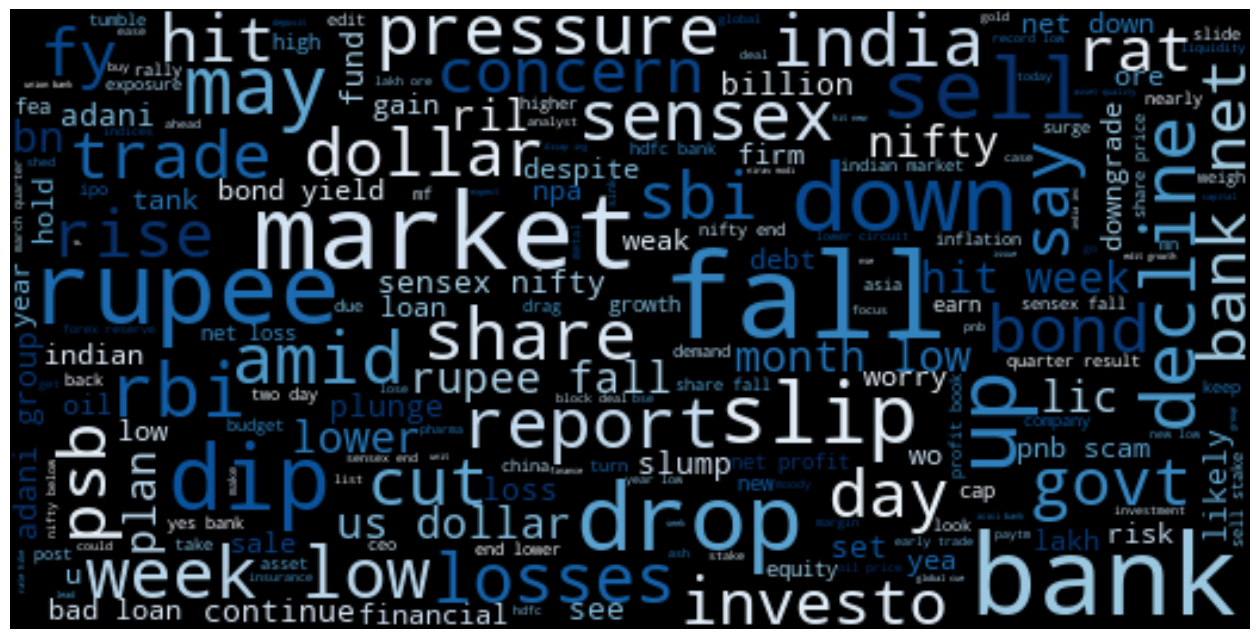

<Figure size 640x480 with 0 Axes>

In [4]:
pos_msg = df[df['Sentiment'] == 1]
zeo_msg = df[df['Sentiment']==0]
nrg_msg = df[df['Sentiment']==2]
pos_msg_text = " ".join(pos_msg.Tok_text.to_numpy().tolist())
zeo_msg_text = " ".join(zeo_msg.Tok_text.to_numpy().tolist())
nrg_msg_text = " ".join(nrg_msg.Tok_text.to_numpy().tolist())

pos_msg_cloud = WordCloud(width =520, height =260, stopwords=new_stopwords,max_font_size=50, background_color ="black", colormap='Blues').generate(pos_msg_text)
# plt.figure(figsize=(16,10))
# plt.imshow(pos_msg_cloud, interpolation='bilinear')
# plt.axis('off') # turn off axis
# plt.show()
# plt.savefig('wordcloud.png', bbox_inches='tight')
# zeo_msg_cloud = WordCloud(width =520, height =260, stopwords=new_stopwords,max_font_size=50, background_color ="black", colormap='Blues').generate(zeo_msg_text)
# plt.figure(figsize=(16,10))
# plt.imshow(zeo_msg_cloud, interpolation='bilinear')
# plt.axis('off') # turn off axis
# plt.show()
# plt.savefig('wordcloud2.png', bbox_inches='tight')
nrg_msg_cloud = WordCloud(width =520, height =260, stopwords=new_stopwords,max_font_size=50, background_color ="black", colormap='Blues').generate(nrg_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(nrg_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()
plt.savefig('negative.png', bbox_inches='tight')


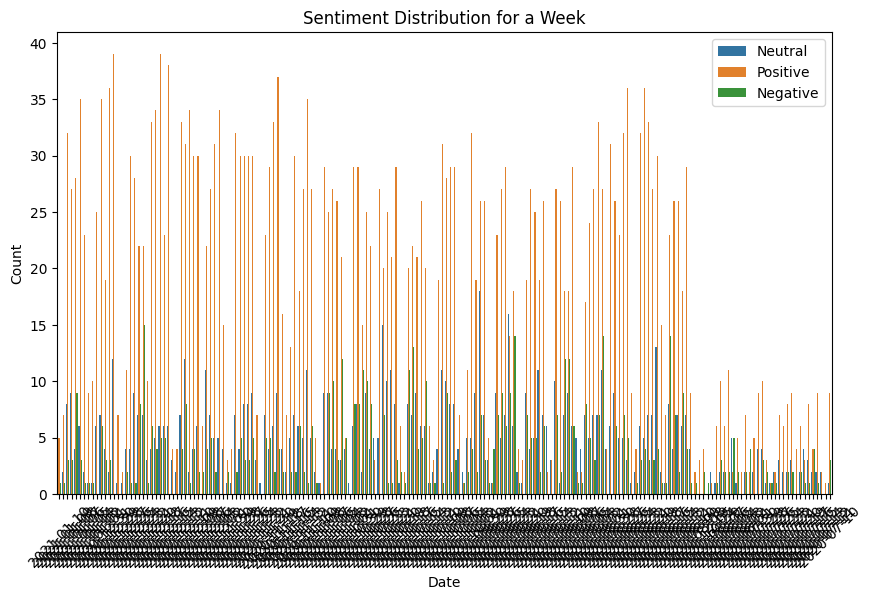

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime

# Set the figure size
plt.figure(figsize=(10, 6))
# today = datetime.date.today()

# Filter the data for a week of dates
# start_date = today - datetime.timedelta(days=today.weekday() + 7)
# end_date = today - datetime.timedelta(days=today.weekday() + 1)
start_date = '2020-07-10'
start_date = datetime.strptime(start_date, "%Y-%m-%d").date()
end_date = '2021-01-10'
end_date = datetime.strptime(end_date, "%Y-%m-%d").date()
week_data = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

sns.countplot(data=week_data, x="Date", hue="Sentiment")

# Plot the bar plot with hue
# ax = week_data['Date'].value_counts().sort_index().plot(kind='bar', color='skyblue', alpha=0.7, hue=week_data['Sentiment'])

# Set the x-axis labels to be rotated for better visibility
plt.xticks(rotation=45)

# Set the x and y-axis labels
plt.xlabel('Date')
plt.ylabel('Count')

# Set the title of the plot
plt.title('Sentiment Distribution for a Week')

# Show the legend
plt.legend(('Neutral','Positive', 'Negative'))

# Display the plot
plt.show()

<Figure size 1500x1800 with 0 Axes>

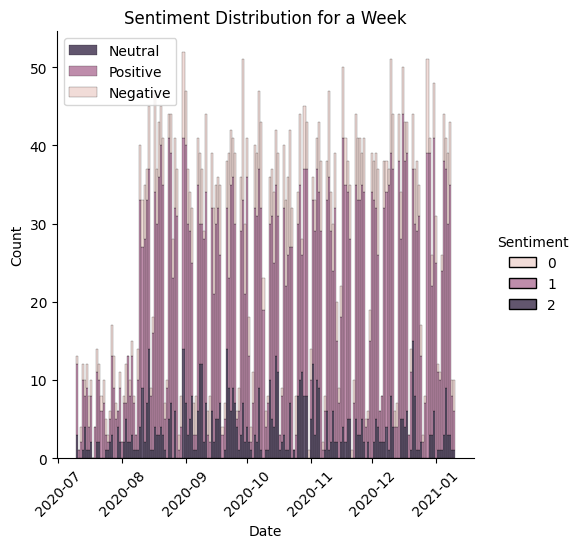

In [33]:
plt.figure(figsize=(15, 18))
sns.displot(data=week_data, x="Date", hue="Sentiment", multiple="stack")
plt.xticks(rotation=45)

# Set the x and y-axis labels
plt.xlabel('Date')
plt.ylabel('Count')

# Set the title of the plot
plt.title('Sentiment Distribution for a Week')

# Show the legend
plt.legend(('Neutral','Positive', 'Negative'))

# Display the plot
plt.show()

In [8]:
import datetime
today = datetime.date.today()
start_date = today - datetime.timedelta(days=today.weekday()+1)
print(start_date)
selected_date = today - datetime.timedelta(days=today.weekday() + 5)
print(selected_date)
print(start_date - datetime.timedelta(6))

2023-05-07
2023-05-03
2023-05-01


In [15]:
nrg_msg = df[df['Sentiment']==2]

In [17]:
df['Sentiment'].value_counts()

Sentiment
1    26995
0    14675
2    11134
Name: count, dtype: int64

In [16]:
nrg_msg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11134 entries, 4 to 52800
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       11134 non-null  object
 1   Date       11134 non-null  object
 2   Sentiment  11134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 347.9+ KB


In [24]:
df['Date'].min()

datetime.date(2003, 2, 11)

In [42]:
start = "2020-01-01"
start_date = datetime.strptime(start, "%Y-%m-%d").date()
end = "2022-12-31"
end_date = datetime.strptime(end, "%Y-%m-%d").date()


# Filter the data for the selected date
neg_msg = df[(df['Date'] >= start_date) & (df['Date'] <= end_date) & (df['Sentiment']==2)]
neg_msg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4788 entries, 810 to 30592
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       4788 non-null   object
 1   Date       4788 non-null   object
 2   Sentiment  4788 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 149.6+ KB


In [48]:
start = "2020-01-01"
start_date = datetime.strptime(start, "%Y-%m-%d").date()
end = "2021-06-30"
end_date = datetime.strptime(end, "%Y-%m-%d").date()


# Filter the data for the selected date
pos_msg = df[(df['Date'] >= start_date) & (df['Date'] <= end_date) & (df['Sentiment']==2)]
pos_msg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1794 entries, 7058 to 30592
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       1794 non-null   object
 1   Date       1794 non-null   object
 2   Sentiment  1794 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 56.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 1794 entries, 7058 to 30592
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       1794 non-null   object
 1   Date       1794 non-null   object
 2   Sentiment  1794 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 56.1+ KB


In [ ]:
nue_msg = df[(df['Date'] >= start_date) & (df['Date'] <= end_date) & (df['Sentiment']==2)]
nue_msg.info()

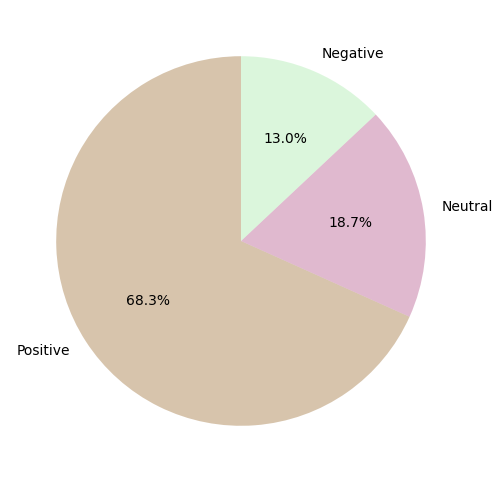

In [34]:
import matplotlib.pyplot as plt
from datetime import datetime
import random

# Set the figure size
plt.figure(figsize=(6, 6))

# Choose a specific date
start = "2022-12-01"
start_date = datetime.strptime(start, "%Y-%m-%d").date()
end = "2023-12-31"
end_date = datetime.strptime(end, "%Y-%m-%d").date()


# Filter the data for the selected date
date_data = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Count the sentiment categories
sentiment_counts = week_data['Sentiment'].value_counts()

# Get the sentiment labels and counts
# sentiment_labels = sentiment_counts.index
sentiment_values = sentiment_counts.values

# Set the colors for each sentiment category
colors = []
for _ in range(3):
    r = random.random()
    g = random.random()
    b = random.random()
    colors.append((r, g, b,0.33))

# Create the pie chart
plt.pie(sentiment_values, labels=['Positive','Neutral', 'Negative'], colors=colors, autopct='%1.1f%%', startangle=90)

# Set the title of the plot
#plt.title('Sentiment Distribution for ' + str(selected_date))
# plt.legend(('Neutral','Positive', 'Negative'))

# Display the plot
plt.show()


In [40]:
date_data['Sentiment'].value_counts()

Sentiment
1    16735
0     5787
2     4788
Name: count, dtype: int64

In [14]:
date_data.to_csv('a.csv',index=False)

([<matplotlib.patches.Wedge at 0x1f579d06bf0>,
 [Text(-0.5476096071382001, 0.9540040451538695, 'low'),
  Text(-1.0993045888131772, 0.03910781270144911, 'fall'),
  Text(-0.8062595926007172, -0.7482950416375386, 'net'),
  Text(-0.26515700613807913, -1.0675634698208303, 'slips'),
  Text(0.33963252866277005, -1.046255105351526, 'loss'),
  Text(0.8057477002049767, -0.7488462082526635, 'dips'),
  Text(1.0591030677864457, -0.29715432321495744, 'pressure'),
  Text(1.0808863277987055, 0.20416842649594402, 'sell'),
  Text(0.8885016578301647, 0.6485096792130778, 'india'),
  Text(0.5580148701365716, 0.9479553811791277, 'drops'),
  Text(0.18788431507411427, 1.0838355429441917, 'global')],
 [Text(-0.2986961493481091, 0.5203658428112015, '16.6%'),
  Text(-0.5996206848071876, 0.021331534200790425, '15.7%'),
  Text(-0.4397779596003912, -0.40816093180229374, '9.3%'),
  Text(-0.14463109425713405, -0.5823073471749982, '9.2%'),
  Text(0.1852541065433291, -0.5706846029190141, '8.6%'),
  Text(0.4394987455663

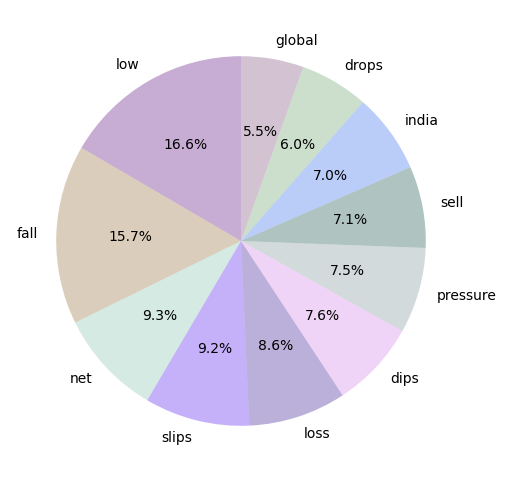

In [23]:
import random
values = {
'low': 762,
'fall': 721,
'net': 425,
'slips': 422,
'loss': 393,
'dips': 350,
'pressure': 345,
'sell': 328,
'india': 321,
'drops': 276,
'global': 251}
colors = []
for _ in range(len(values.keys())):
    r = random.random()
    g = random.random()
    b = random.random()
    colors.append((r, g, b,0.33))
plt.figure(figsize=(6, 6))
plt.pie(values.values(), labels=values.keys(), colors=colors, autopct='%1.1f%%', startangle=90)
#plt.title("The top 10 most common words in postive sentiment news")


In [32]:
sentiment = df['Sentiment'].value_counts()
sentiment.keys

<bound method Series.keys of Sentiment
1    26995
0    14675
2    11134
Name: count, dtype: int64>

([<matplotlib.patches.Wedge at 0x2777b348a90>,
 [Text(-0.8899187180267095, 0.6465637441936395, 'Positive'),
  Text(-0.6465637025335373, -0.8899187482945414, 'Neutral'),
  Text(1.0999999999999954, 1.0298943244593887e-07, 'Negative')],
 [Text(-0.48541020983275057, 0.3526711331965306, '30.0%'),
  Text(-0.35267111047283856, -0.4854102263424771, '20.0%'),
  Text(0.5999999999999974, 5.6176054061421195e-08, '50.0%')])

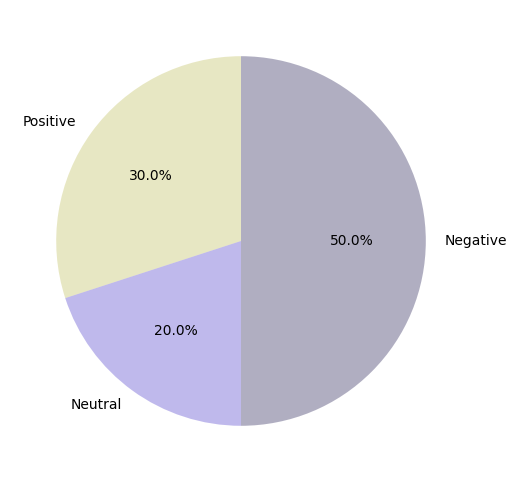

In [45]:
sentiment = df['Sentiment'].value_counts()
colors = []
for _ in range(3):
    r = random.random()
    g = random.random()
    b = random.random()
    colors.append((r, g, b,0.33))
plt.figure(figsize=(6, 6))
sentiment_values = sentiment_counts.values
plt.pie([120, 80,200], labels=['Positive','Neutral', 'Negative'], colors=colors, autopct='%1.1f%%', startangle=90)

In [11]:
from datetime import datetime

def format_date(timestamp):
    dt = datetime.strptime(str(timestamp), '%Y-%m-%d %H:%M:%S')
    formatted_date = dt.strftime('%Y-%m-%d')
    return formatted_date

df['Date']=df['Date'].apply(format_date)

# Print the formatted date
# print(formatted_date)

In [12]:
df['Date'] = pd.to_datetime(df['Date']).dt.date

In [16]:
df.to_csv('stock_data.csv',index=False)

In [9]:
df['Date'].max()

Timestamp('2023-05-01 00:26:00')

In [1]:
# df['Date'] = pd.to_datetime(df['Date']) - pd.to_timedelta(7, unit='d')
# df1 = df.groupby(['Text', pd.Grouper(key='Date', freq='W-MON')])['Quantity'].sum().reset_index().sort_values('Date')
# print (df)

In [63]:
import seaborn as sns

c:\Users\kings\OneDrive\Documents\Stock-Analysis\envr\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\kings\OneDrive\Documents\Stock-Analysis\envr\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

Best Hyperparameters: {'C': 10, 'penalty': 'l2'}
Best Accuracy: 0.8834748106170398
Test Accuracy: 0.8935109203383411


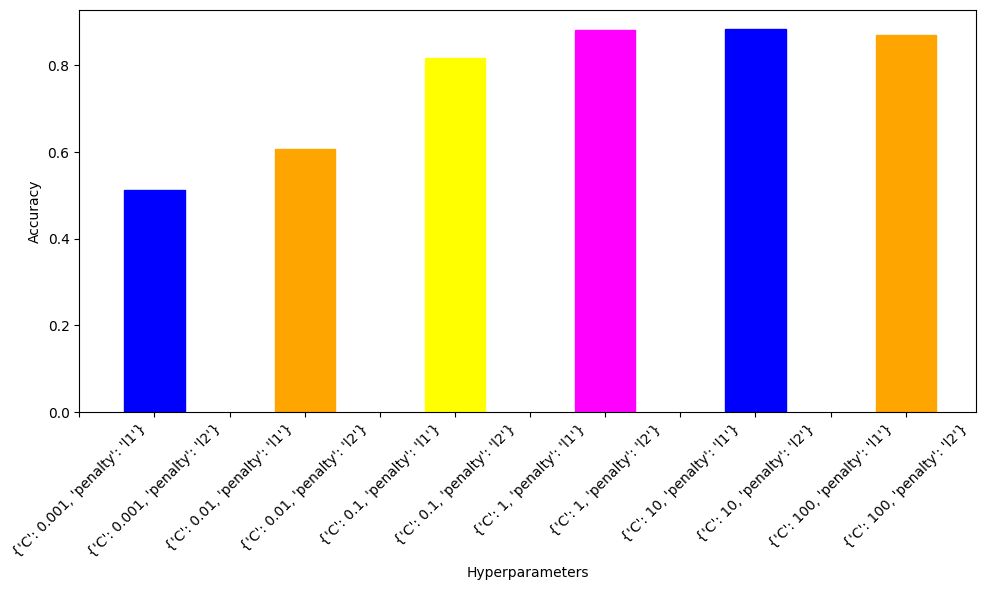

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# # Load the dataset
# data = pd.read_csv('your_dataset.csv')

# # Separate the features and target variable
# X = data.drop('target', axis=1)
# y = data['target']

# # Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameters grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Create the logistic regression model
model = LogisticRegression(solver='lbfgs',multi_class='multinomial')

# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and corresponding accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

# Print the best hyperparameters and accuracy
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

# Get the predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Get all hyperparameter combinations and accuracies
results = grid_search.cv_results_
hyperparameters = results['params']
accuracies = results['mean_test_score']

# ...

# Define colors for each bar
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta']

# Plot the accuracies for each set of hyperparameters with different colors
plt.figure(figsize=(10, 6))
x_ticks = np.arange(len(hyperparameters))
bars = plt.bar(x_ticks, accuracies)

# Set the color of each bar
for i in range(len(bars)):
    bars[i].set_color(colors[i % len(colors)])

plt.xticks(x_ticks, hyperparameters, rotation=45)
plt.xlabel('Hyperparameters')
plt.ylabel('Accuracy')
# plt.title('Accuracy for Different Hyperparameter Combinations')
plt.tight_layout()
plt.show()



              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4403
           1       0.91      0.93      0.92      8099
           2       0.89      0.84      0.87      3340

    accuracy                           0.89     15842
   macro avg       0.89      0.88      0.88     15842
weighted avg       0.89      0.89      0.89     15842

0.8933215503093044 SDG
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4403
           1       0.91      0.92      0.91      8099
           2       0.89      0.85      0.87      3340

    accuracy                           0.89     15842
   macro avg       0.89      0.88      0.89     15842
weighted avg       0.89      0.89      0.89     15842

0.8933215503093044 LR


c:\Users\kings\OneDrive\Documents\Stock-Analysis\envr\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


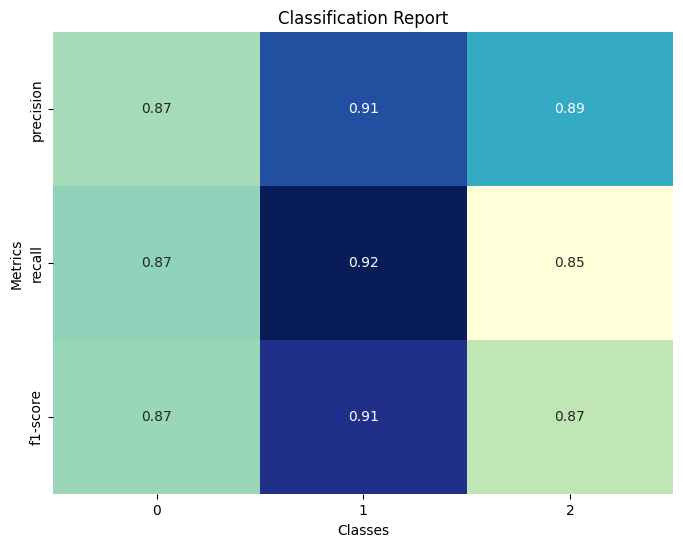

In [76]:
clf1 = SGDClassifier(alpha=0.0001,loss='modified_huber')
clf1.fit(X_train,y_train)
y_pred = clf1.predict(X_test)
print(classification_report(y_test, y_pred))
score = accuracy_score(y_pred,y_test)
print(score,"SDG")

clf2 = LogisticRegression(C=10,multi_class='multinomial',penalty='l2',solver='lbfgs')
clf2.fit(X_train,y_train)
y_pred2 = clf2.predict(X_test)
print(classification_report(y_test,y_pred2))
score1 = accuracy_score(y_pred2,y_test)
print(score, "LR")
report = classification_report(y_test, y_pred2, output_dict=True)

# Convert the report to a DataFrame for easier visualization
report_df = pd.DataFrame(report).transpose()

# Plot the classification report
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:3,:3].T, annot=True, cmap='YlGnBu', cbar=False)
plt.title('Classification Report')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()

In [73]:
report_df.head()
report_df.iloc[:3,:3].head()

,precision,recall,f1-score
0,0.871859,0.874631,0.873243
1,0.906960,0.921966,0.914401
2,0.888784,0.849401,0.868647


In [34]:
# a = [ 'NewsData-2023-05-01.csv',
# 'NewsData-2023-05-02.csv',
# 'NewsData-2023-05-03.csv',
# 'NewsData-2023-05-04.csv',
# 'NewsData-2023-05-05.csv','bs.csv']
# import os 

# for file in os.listdir('./raw_news'):
#     if file not in a:
#         os.remove("./raw_news/"+file)
#         print(file)

In [48]:
import pickle
pickle.dump(clf2, open('model1.pkl', 'wb'))
# pickle.dump(tf_idf_vect, open("vectorizer.pkl", "wb"))


In [111]:
test_data.head()

,Unnamed: 0,Text,Tok_text
0,0,"Banks, realty, auto stocks surge on RBI’s booster package",bank realty auto surge rbi booster package
1,1,Sebi increases scrutiny of FPIs from 11 Asian countries,sebi ease utiny fpis asian countries
2,2,"Market seen on edge ahead of RBI governor's address; RIL, TCS in focus",market see edge ahead rbi governor address ril tcs focus
3,3,"Stocks to Watch: TCS, IndiGo, Reliance Industries, SpiceJet, Motherson Sumi",watch tcs indigo reliance industries spicejet mothe sumi
4,4,Asian stocks climb as US paves way to reopen economy,asian climb us pave way reopen economy


In [73]:
y_pred = clf1.predict(x_test)
check = pd.DataFrame({'Text':test_data['Text'],'Date':test_data['Date'],'Sentiment':y_pred})
# check = pd.DataFrame({'Text':all_df['Text'],'Date':all_df['Date'],'Sentiment':y_pred})
check.to_csv('check.csv',index=False)

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47066 entries, 0 to 47065
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Text       47066 non-null  object        
 1   Date       47066 non-null  datetime64[ns]
 2   Sentiment  47066 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.1+ MB


In [10]:
df.drop(columns=['Tok_text'], axis=1,  inplace=True)

In [74]:
df1 = pd.read_csv('check.csv')
print(df1.info())
print(df.info())
fg = pd.concat([df,df1],ignore_index=True)
# fg.info()
fg.to_csv('stock_data.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       154 non-null    object
 1   Date       154 non-null    object
 2   Sentiment  154 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52650 entries, 0 to 52649
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Text       52650 non-null  object        
 1   Date       52650 non-null  datetime64[ns]
 2   Sentiment  52650 non-null  int64         
 3   Tok_text   52650 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.6+ MB
None


In [51]:
import pandas as pd
import numpy as np
df33 = pd.read_csv('check.csv')
df33['Text'] = df33['Text'].astype(str)
df33.drop_duplicates(subset="Text",
                     keep=False, inplace=True)
df33['Date'] = pd.to_datetime(df33['Date'])
df33['Sentiment'] = df33['Sentiment'].astype(np.int64)
print(df33.info())


<class 'pandas.core.frame.DataFrame'>
Index: 5605 entries, 0 to 6198
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Text       5605 non-null   object        
 1   Date       5605 non-null   datetime64[ns]
 2   Sentiment  5605 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 175.2+ KB
None


c:\Users\kings\OneDrive\Documents\Stock-Analysis\envr\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
C:\Users\kings\AppData\Local\Temp\ipykernel_16884\2133166450.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df33['Date'] = pd.to_datetime(df33['Date'])


In [70]:
df33['Sentiment'].value_counts()

Sentiment
1    3121
0    1148
2     758
Name: count, dtype: int64

In [69]:
# df = df[df['Text'].str.contains('Wall St')==False]
df33.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5027 entries, 0 to 6198
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Text       5027 non-null   object        
 1   Date       5027 non-null   datetime64[ns]
 2   Sentiment  5027 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 157.1+ KB


In [46]:
a = [3,2,3]
print(max(a,key=a.count))

3


In [95]:
df33.to_csv('check.csv',index=False)

In [68]:
df33 = df33[df33['Text'].str.contains('\?')!=True]

In [31]:
df33.loc[df33['Text'].str.contains('\?')&(df33['Sentiment']==1), 'Sentiment']= 0

In [ ]:
df33[df33['Text'].str.contains(' scam ')& (df33['Sentiment']==1)

In [94]:
#df.iloc[301, df.columns.get_loc('Sentiment')] = 1
df33.at[1029, 'Sentiment'] = 2

In [33]:
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

In [92]:
df33[df33['Text'].str.contains(' risk')&  (df33['Sentiment']==1)][['Text','Sentiment']]

,Text,Sentiment
532,Sensex rises for 2nd straight day on improved risk sentiment; investors gain Rs 2.12L cr,1
578,Global mkts fully pricing in Fed hike to 5.5%; Indian equities at risk: UBS,1
1029,"20% of Titan's fair value at risk, says ICICI Securities: Here's why",1
1299,"Jefferies explains SVB Financial Group's India connection, potential risks",1
2076,Brokerage firm Nirmal Bang sees favourable risk-reward in pharma,1
2148,SVB fallout: Zerodha CEO on investing in govt bonds without taking risks,1
2340,Why markets are in uproar over a risky bank bond known as AT1,1
2451,Systemic credit event in US shadow banks the biggest tail risk for markets,1
2592,"TVS Motors turned ""electrification risk into an opportunity"", 47% upside expected: Jefferies",1
2599,Economic fallout of banking crisis a bigger risk for IT sector,1
